In [12]:
using LombScargle, Deconvolution, Plots, Statistics


In [13]:
t = range(0, stop=10, length=1000) # observation times
x = sinpi.(t) .* cos.(5t) - 1.5cospi.(t) .* sin.(2t) # the original signal
n = rand(length(x)) # noise to be added
y = x + 3(n .- mean(n)) # observed noisy signal

1000-element Vector{Float64}:
  0.26453707735261667
 -0.7689476175856242
  0.20633354216085836
 -1.2036395671496114
  0.29320608925182834
 -0.9810742221009333
  1.2622798426176878
  1.4477077788340156
 -1.3178378776708064
 -0.025482826816527138
  0.15219563172430112
  0.6631610111223252
  0.8694804725205976
  ⋮
 -0.2016323347977289
 -0.31935168561647065
 -2.7343963263210327
 -1.121425177423728
 -2.1999347785401984
 -1.874023013429501
 -0.32935578765165285
 -0.1916019622125371
 -1.5678547758460653
  0.010022113351672912
 -2.193296545504109
 -2.6644823100199697

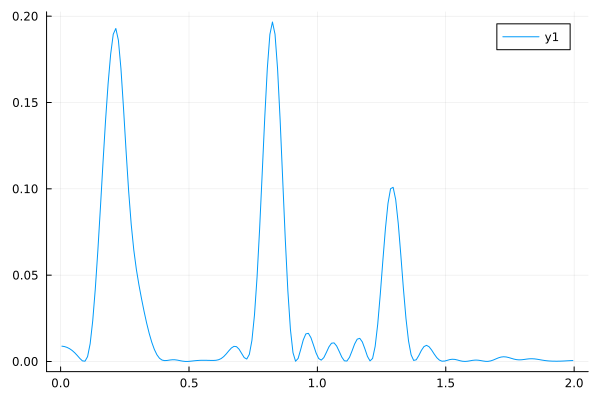

In [14]:
# Lomb-Scargle periodogram
p = lombscargle(t, y, maximum_frequency=2, samples_per_peak=10)
plot(freqpower(p)...)

In [15]:
m1 = LombScargle.model(t, y, findmaxfreq(p, [0, 0.5])[1]) # first model
m2 = LombScargle.model(t, y, findmaxfreq(p, [0.5, 1])[1]) # second model
m3 = LombScargle.model(t, y, findmaxfreq(p, [1, 1.5])[1]) # third model

1000-element Vector{Float64}:
  0.07663213983494378
  0.12098049354946408
  0.1647170339183846
  0.20755177788596746
  0.24920072150853773
  0.28938772296422166
  0.3278463334350569
  0.36432156372231633
  0.3985715748819906
  0.43036928167113714
  0.459503858173888
  0.48578213562447825
  0.5090298831594153
  ⋮
 -0.46622745947271094
 -0.4452303022551237
 -0.42109085402613333
 -0.3939691647325819
 -0.36404505724733727
 -0.3315169351033595
 -0.2966004670338671
 -0.2595271570403418
 -0.22054280946915644
 -0.17990589927374262
 -0.1378858582677413
 -0.0947612887317712

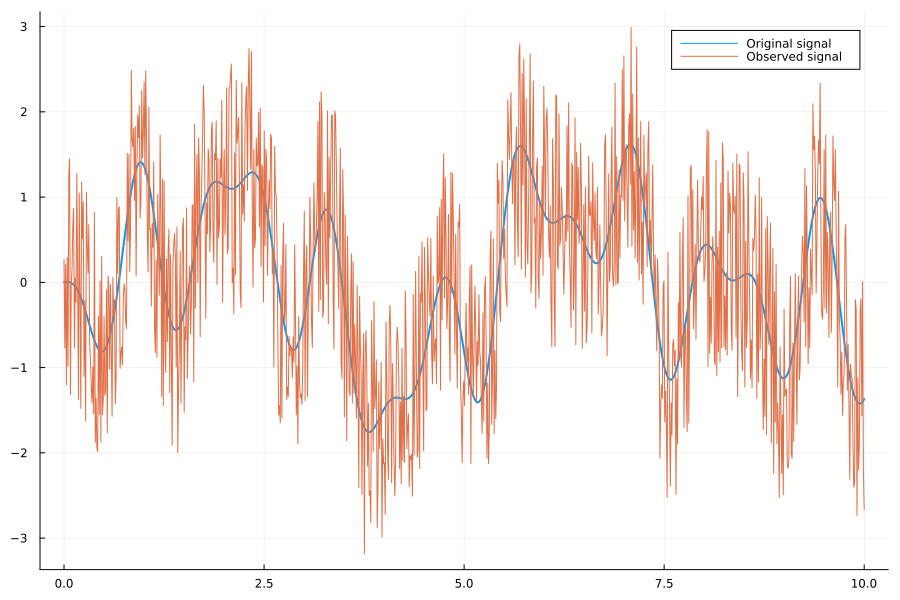

In [16]:
signal = m1 + m2 + m3 # signal for `wiener`
noise = rand(length(y)) # noise for `wiener`
polished = wiener(y, signal, noise)
plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, y, label="Observed signal")
#savefig("time-series-observed.png")


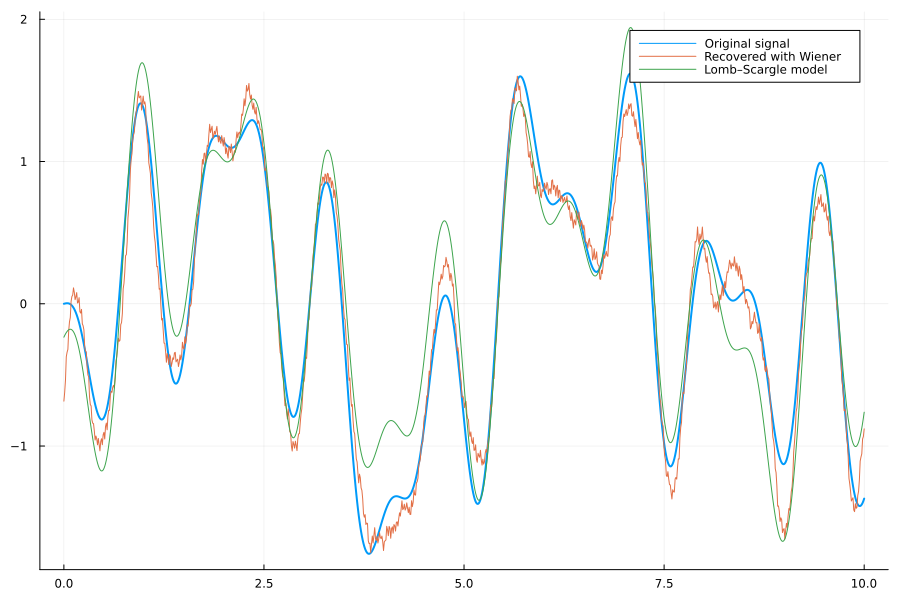

In [30]:
plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, polished, label="Recovered with Wiener")
plot!(t, signal, label="Lomb–Scargle model")
#savefig("time-series-recovered.png")

In [1]:
# Gaussian blurring kernel
kernel = exp.( - 10 .* (t .- 5).^2)
kernel ./= sum(kernel) # normalize kernel to sum of 1
kernel = ifftshift(kernel) # move center to index pos 1

#y_blurred = real(ifft(fft(kernel) .* fft(x))) + noise
y_blurred = DSP.conv(x, kernel) + randn(1999)


deblurred = wiener(y_blurred, signal, noise, kernel)

plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, y_blurred, label="Blurred signal")
plot!(t, deblurred, label="Deblurred with Wiener")

LoadError: UndefVarError: t not defined

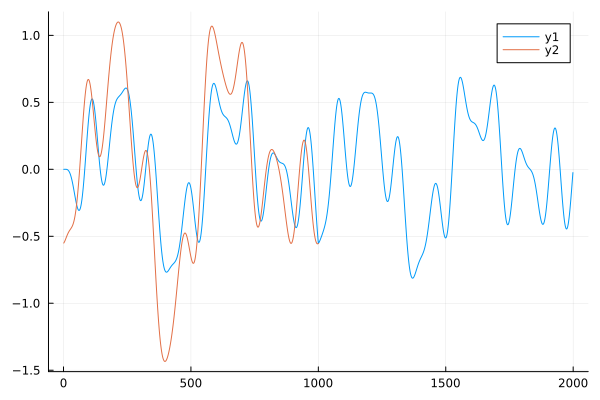

In [24]:
using DSP
plot(DSP.conv(x, kernel))
plot!(real(ifft(fft(kernel) .* fft(x))))

In [41]:
using Distributions
function spm_Gpdf(x, α, β)
    k = α
    Θ = 1/β
    dist = Gamma(α,Θ)
    return pdf.(dist, x)
end

function spm_hrf(RT)
    p = [6., 16., 1., 1., 6., 0., 32.]
    fMRI_T=16
    
    dt = RT / fMRI_T
    u = (range(0, ceil(Int64,p[7]/dt), step=1) |> collect) .- (p[6]/dt)
    
    hrf = spm_Gpdf(u, p[1]/p[3], dt/p[3]) - spm_Gpdf(u, p[2]/p[4], dt/p[4])/p[5]
    print(range(0, floor(Int64,p[7]/RT)))
    hrf = hrf[range(0, floor(Int64,p[7]/RT))*fMRI_T .+ 1]
    return hrf/sum(hrf)
end


signal = DSP.conv(x, spm_hrf(1.2)) + randn(1026)/10
restored_img_200 = lucy(signal, spm_hrf(1.2), iterations=200)
plot(signal)

0:260:26

LoadError: AssertionError: size(observed) == size(psf)

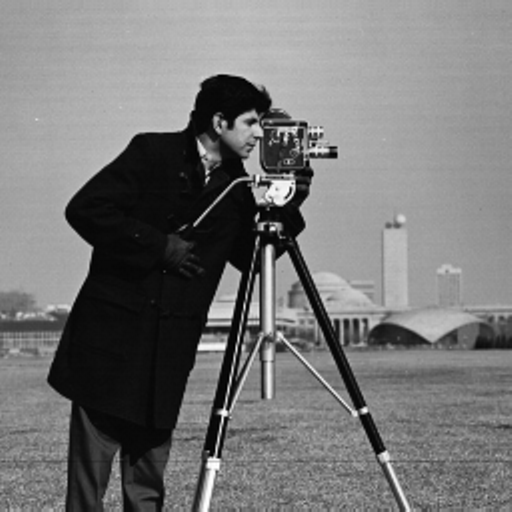

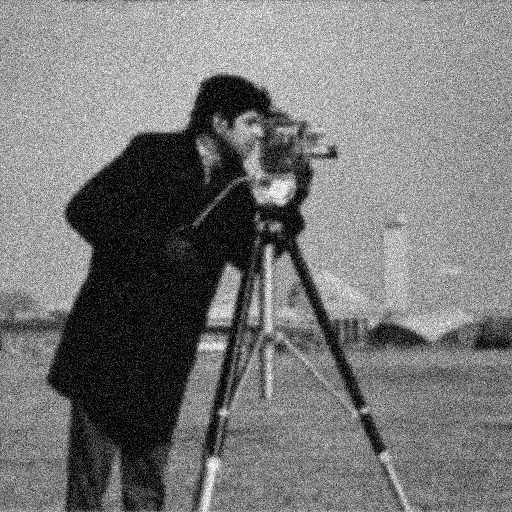

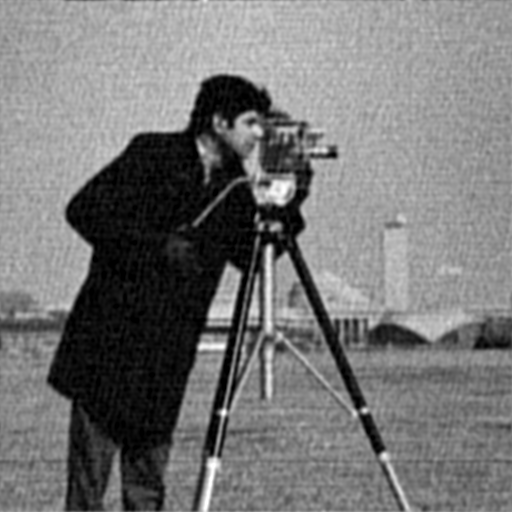

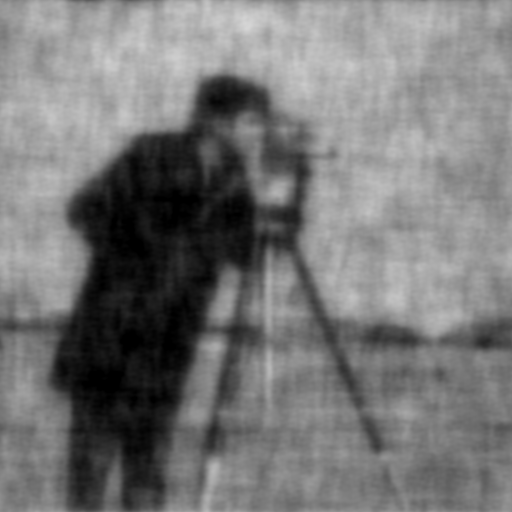

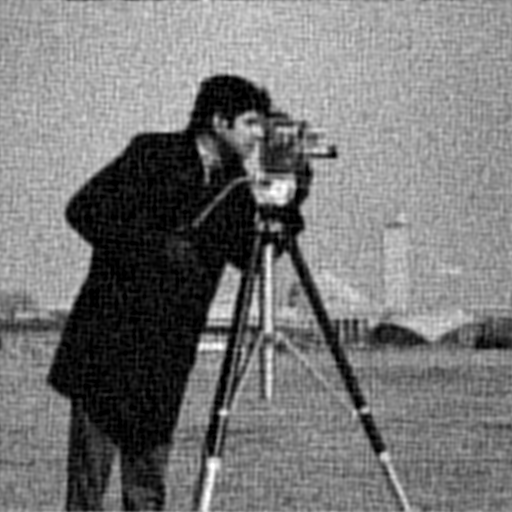

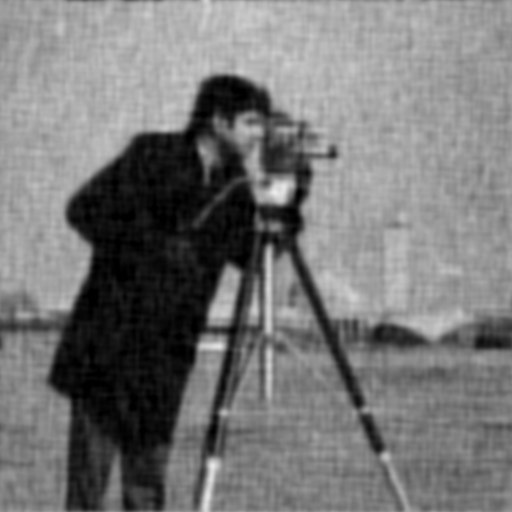

In [8]:
using Images, TestImages, Deconvolution, ImageView

# Open the test image
img = Float32.(testimage("cameraman"))
# Create the blurring kernel in frequency domain
x = hcat(ntuple(x -> collect((1:512) .- 257), 512)...)
k = 0.001
blurring_ft = exp.(-k*(x .^ 2 + x' .^ 2).^(5//6))
# Create additive noise
noise = randn(size(img)) ./ 10
# Fourier transform of the blurred image, with additive noise
blurred_img_ft = fftshift(blurring_ft) .* fft(img) + fft(noise)
# Get the blurred image from its Fourier transform
blurred_img = real(ifft(blurred_img_ft))
# Get the blurring kernel in the space domain
blurring = ifft(fftshift(blurring_ft))
# Polish the image with Deconvolution deconvolution
polished = wiener(blurred_img, img, noise, blurring)

# Wiener deconvolution works also when you don't have the real image and noise,
# that is the most common and useful case.  This happens because the Wiener
# filter only cares about the power spectrum of the signal and the noise, so you
# don't need to have the exact signal and noise but something with a similar
# power spectrum.
img2 = Float32.(testimage("livingroom")) # Load another image
noise2 = randn(size(img)) # Create another additive noise
# Polish the image with Deconvolution deconvolution
polished2 = wiener(blurred_img, img2, noise2, blurring)

# Wiener also works using a real number instead of a noise array
polished3 = wiener(blurred_img, img2, 1000, blurring)
polished4 = wiener(blurred_img, img2, 10000, blurring)


# Compare...
display(colorview(Gray, img)) # ...the original image
display(colorview(Gray, blurred_img)) # ...the blurred image
display(colorview(Gray, polished)) # ...the polished image
display(colorview(Gray, polished2)) # ...the second polished image
display(colorview(Gray, polished3)) # ...the third polished image
display(colorview(Gray, polished4)) # ...the fourth polished image

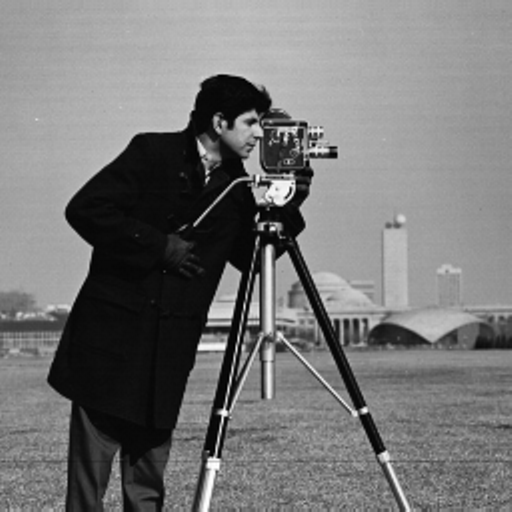

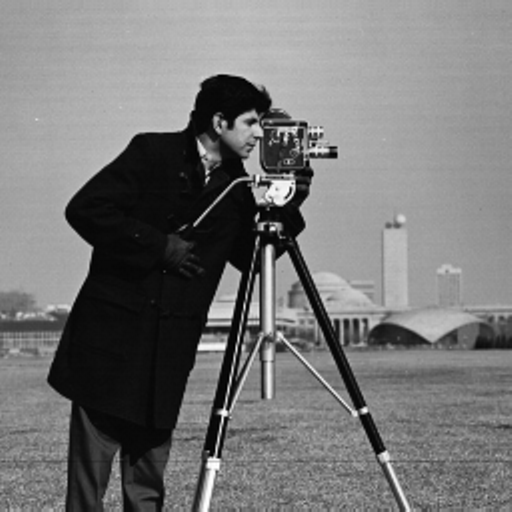

In [6]:


display(colorview(Gray, img))
display(colorview(Gray, img))

  4.975768 seconds (25.30 k allocations: 7.062 GiB, 2.93% gc time)
 56.018350 seconds (252.09 k allocations: 70.358 GiB, 2.44% gc time)


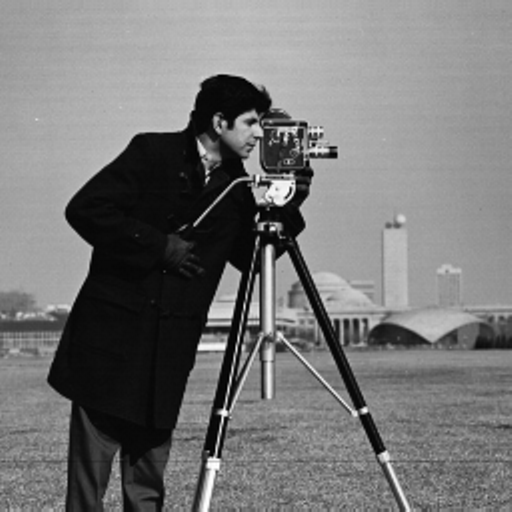

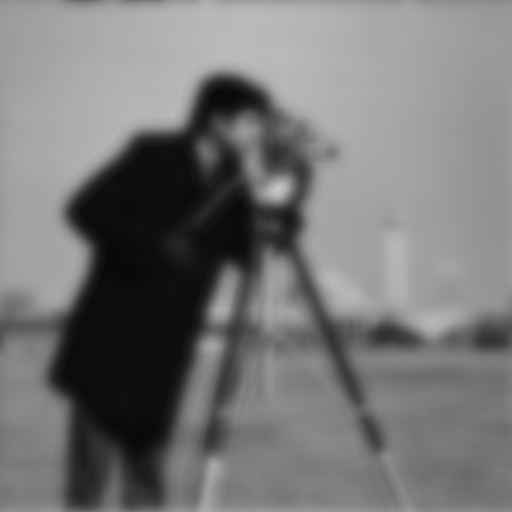

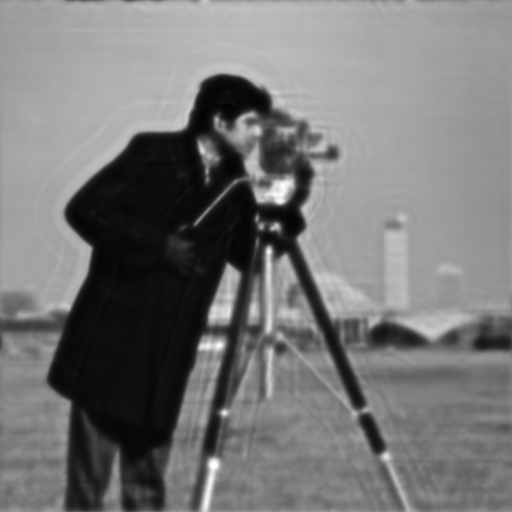

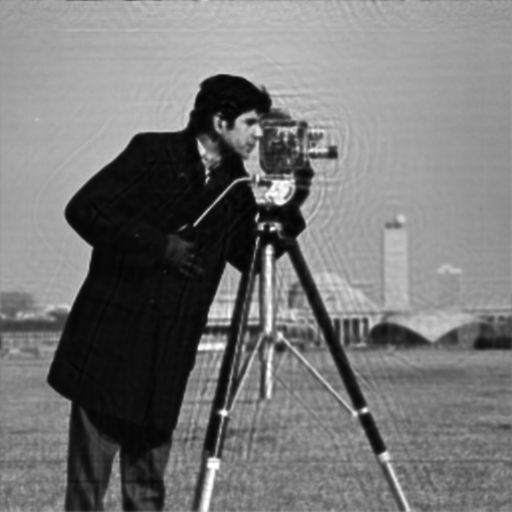

In [40]:
using Images, TestImages, Deconvolution, FFTW, ZernikePolynomials, ImageView

img = channelview(testimage("cameraman"))

# model of lens aberration
blurring = evaluateZernike(LinRange(-16,16,512), [12, 4, 0], [1.0, -1.0, 2.0], index=:OSA)
blurring = fftshift(blurring)
blurring = blurring ./ sum(blurring)

blurred_img = fft(img) .* fft(blurring) |> ifft |> real

@time restored_img_200 = lucy(blurred_img, blurring, iterations=200)
@time restored_img_2000 = lucy(blurred_img, blurring, iterations=2000)

display(colorview(Gray, img))
display(colorview(Gray, blurred_img))
display(colorview(Gray, restored_img_200))
display(colorview(Gray, restored_img_2000))


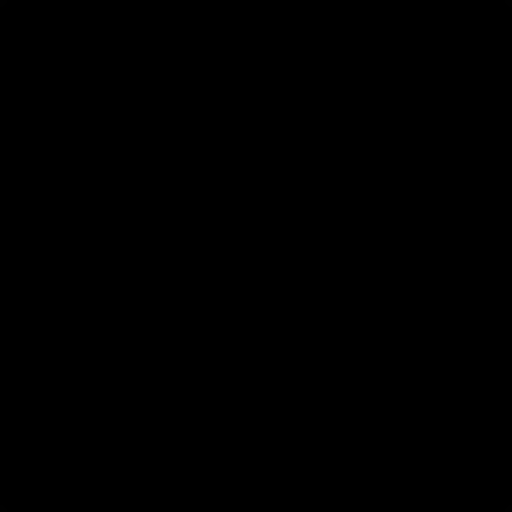

In [42]:
display(colorview(Gray, blurring))

In [43]:
blurring

512×512 Matrix{Float64}:
 0.00364388   0.00356336   0.00340535   …  0.00356336   0.00364388
 0.00356336   0.00348385   0.00332786      0.00348385   0.00356336
 0.00340535   0.00332786   0.00317593      0.00332786   0.00340535
 0.00317593   0.00310149   0.00295564      0.00310149   0.00317593
 0.00288423   0.00281384   0.0026761       0.00281384   0.00288423
 0.00254241   0.00247709   0.00234948   …  0.00247709   0.00254241
 0.00216567   0.00210642   0.00199098      0.00210642   0.00216567
 0.00177224   0.00172009   0.00161883      0.00172009   0.00177224
 0.00138342   0.00133937   0.00125433      0.00133937   0.00138342
 0.00102351   0.00098859   0.000921785     0.00098859   0.00102351
 0.000719892  0.000695104  0.000648568  …  0.000695104  0.000719892
 0.000502958  0.000489317  0.000465076     0.000489317  0.000502958
 0.000406152  0.000404672  0.000404752     0.000404672  0.000406152
 ⋮                                      ⋱  ⋮            
 0.000502958  0.000489317  0.000465076  …  0